# Tutorial: WHO Decision Support Simulator (Dengue Model)

**Last updated:** 10 October 2025

Welcome! This notebook summarises the key features of the Dengue Model contained in the WHO Decision Support Simulator. If you would like to obtain access to the full code, please send your GitHub username to Chloe Rice at Collaboratory@who.int.

In this exercise, we will be running the Dengue model with mobility and no age stratification.

## How to use this notebook

- **Run cells in order** from top to bottom.
- Code cells are grouped under clear headings so you can jump to the part you need.

### Prerequisites
- Python 3.10+ recommended
- Common scientific stack (NumPy, pandas, matplotlib). If you're in a managed environment, these are often pre-installed.

### Troubleshooting
- Kernel errors? Try **Kernel → Restart & Run All**.  
- Missing package? Install it in a cell with `!pip install <package>` then re-run.  
- Path issues? Print `os.getcwd()` and use absolute paths.


## Setup


In [ ]:
import os
os.environ["JAX_ENABLE_X64"] = "1"  # must be set BEFORE importing jax

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import jit
from jax import lax
from jax import config
config.update("jax_enable_x64", True)

import pandas as pd
import sys

import geopy.distance
import json
import numpy as np

np.set_printoptions(suppress=True, threshold=sys.maxsize) # Suppresses scientific notation globally for NumPy arrays and prints out full arrays

## Define key parameters



In [ ]:
# Dengue default parameters
delta_H = 1/5.9    # Host incubation period
eta = 1/5          # Host recovery rate from infectiousness
E_a = 0.05         # Activation energy
k = 8.617e-5       # Boltzmann-Arrhenius constant
N_v_m = 1.5        # Maximum carrying capacity
T_0 = 29           # Reference temperature where carrying capacity is greatest
kappa = 1e-5       # Helper population for mosquitos
theta = 0.05       # hospitalization rate (from infected). This value is from pg. 4 of Paz-Bailey et al.
omega = 1/4.9      # recovery rate from hospitalization
zeta = 1 / 240     # Rate of loss of cross-protection/immunity period
mu = 1 / (73 * 365) # global death rate for 73-year lifespan

## Define helper functions

Please note the following:

* Contact matrix = gravity matrix

* Beta = transmission_rate * contact_matrix

* Transmission rates are different for humans and vectors, these come from the formulas in Huber and Cummings

* Human transmission rate = mosquito biting rate * probability of mosquito infectiousness (probability of human infection per bite of an infectious mosquito - gamma_T in the model).  

* Human Force of Infection (FOI) = Human transmission rate * proportion of infectious mosquitos (these are multiplied using the dot product, since these are matrices in the shape of number_of_regions rows x 1 column, we will get a FOI calculation for each region)

* Vector transmission rate = mosquito biting rate * probability of infection per bite on infectious host. Since the mosquitos are not traveling, we do not need to multiply by a contact_matrix (we multiply by the identity matrix).   

* Vector FOI = vector transmission rate *  the number of infectious hosts for that serotype (people currently in their first or 2nd infection for the serotype of interest - e.g. I1 + I21 + I31 + I41)/total number of people in that region

* Note that the mosquito bite rate, the probability of mosquito infectiousness, and the probability of infection per bite on infectious host, which are used to calculate transmission rates for humans and vectors, are temperature-dependent so if there are different temperatures in different sub-regions, then those numbers will be different (but can easily be put in a matrix)


In [ ]:
# Temperature related parameters
def temperature_seasonality_jax(Tmax, Tmin, Tmean, numeric_day, hemisphere):
    '''
    Calculates temperature using a sin curve to represent seasonality for each day of simulation.
    Compatible with JAX transformations (e.g., odeint, grad).
    '''

    def temp_north(_):  # 0 = Northern Hemisphere
        temp = ((Tmax - Tmin) / 2) * jnp.cos((2 * jnp.pi / 365) * (numeric_day + (365 / 2))) + Tmean
        return jnp.clip(temp, Tmin, Tmax)

    def temp_south(_):  # 1 = Southern Hemisphere
        temp = ((Tmax - Tmin) / 2) * jnp.cos((2 * jnp.pi / 365) * numeric_day) + Tmean
        return jnp.clip(temp, Tmin, Tmax)

    return lax.cond(hemisphere == 0, temp_north, temp_south, operand=None)


def briere_jax(temp, c, Tmin, Tmax):
    '''
    Fits Brière function to calculate thermal responses.
    Fully JAX-compatible version using lax.cond.
    '''
    def in_range(_):
        return c * temp * (temp - Tmin) * jnp.sqrt(Tmax - temp)

    def out_of_range(_):
        return jnp.array(0.0)

    return lax.cond(
        (temp < Tmin) | (temp > Tmax),
        out_of_range,
        in_range,
        operand=None
    )


def quadratic_jax(temp, c, Tmin, Tmax):
    '''Fits quadratic function to calculate thermal responses.'''
    def in_range(_):
        return c * (temp - Tmin) * (temp - Tmax)

    def out_of_range(_):
        return jnp.array(0.0)

    return lax.cond(
        (temp < Tmin) | (temp > Tmax),
        out_of_range,
        in_range,
        operand=None
    )


def calculate_death_rate_jax(temp, c, Tmin, Tmax):
    '''
    Fits quadratic function to calculate the inverse of mosquito lifespan
    as death rate (see pg. 7 of Huber).
    '''
    def in_range(_):
        return 1.0 / (c * (temp - Tmin) * (temp - Tmax))

    def out_of_range(_):
        return jnp.array(24.0)

    return lax.cond(
        (temp <= Tmin) | (temp >= Tmax),
        out_of_range,
        in_range,
        operand=None
    )


def calculate_surviving_offspring(T0=29):
    l_V_T0 = briere_jax(T0, 8.56e-3, 14.58, 34.61)   # number of eggs laid per female
    s_V_T0 = quadratic_jax(T0, -5.99e-3, 13.56, 38.29)  # egg-to-adult survival
    d_V_T0 = briere_jax(T0, 7.86e-5, 11.36, 39.17)   # dev rate
    mu_V_T0 = calculate_death_rate_jax(T0, -1.48e-1, 9.16, 37.73)

    return (l_V_T0 * s_V_T0 * d_V_T0) / mu_V_T0, mu_V_T0


def get_carrying_capacity(temperature, vector_surviving_offspring, mu_V_T0, N_v_m, E_a, N, T0, k):
    #return ((vector_surviving_offspring - mu_V_T0) / vector_surviving_offspring) * N_v_m * N * np.exp((-E_a) * ((temperature - T0)**2)) / (k * (temperature + 273.15) * (T0 + 273.15))
    return ((vector_surviving_offspring - mu_V_T0) / vector_surviving_offspring) * N_v_m * N * jnp.exp((-E_a) * ((temperature - T0)**2) / (k * (temperature + 273.15) * (T0 + 273.15)))



def calculate_thermal_responses(temperature):
    l_V_T = briere_jax(temperature, 8.56e-3, 14.58, 34.61)        # eggs per female
    s_V_T = quadratic_jax(temperature, -5.99e-3, 13.56, 38.29)    # survival
    d_V_T = briere_jax(temperature, 7.86e-5, 11.36, 39.17)        # dev rate
    epsilon_V_T = briere_jax(temperature, 6.65e-5, 10.68, 45.90)  # virus incubation
    delta_V_T = briere_jax(temperature, 4.91e-4, 12.22, 37.46)    # infection prob
    gamma_T = briere_jax(temperature, 8.49e-4, 17.05, 35.83)      # infectiousness
    b_V_T = briere_jax(temperature, 2.02e-4, 13.35, 40.08)        # biting rate
    mu_V_T = calculate_death_rate_jax(temperature, -1.48e-1, 9.16, 37.73)

    return l_V_T, s_V_T, d_V_T, epsilon_V_T, delta_V_T, gamma_T, b_V_T, mu_V_T


In [ ]:
#Gravity model
def get_travel_volume(travel_volume, case_file, default_leaving=0.2, default_returning=0.1):
    if len(case_file) == 1:
        # if 1 sub-admin zone, default no travel
        leaving = float(0)
        returning = float(0)
    else:
        if travel_volume:
            # Assigns defaults and checks for None values
            leaving =  travel_volume.get("leaving", default_leaving) / 100 if travel_volume.get("leaving") is not None else default_leaving
            returning = travel_volume.get("returning", default_returning) / 100 if travel_volume.get("returning") is not None else default_returning
        else:
            # Handle travel_volume: None case
            leaving = default_leaving,
            returning = default_returning
    return {
        "leaving": leaving,
        "returning": returning
    }

def get_admin_zone_df(case_file):
    ll_pop = pd.DataFrame(case_file, columns=["id", "center_lat", "center_lon", "population"])
    ll_pop['lat_long'] = list(zip(ll_pop.center_lat, ll_pop.center_lon))
    ll_pop.drop(columns=['center_lat', 'center_lon'], inplace=True)

    #Create df with Cartesian product for calculations between locations
    cross_df = ll_pop.merge(ll_pop, how='cross', suffixes=['_origin', '_destination'])
    return cross_df


def gravity_model(df, mass_origin_col, mass_dest_col, distance_col, k=1):
    """
    Calculates the gravity model for a given dataframe.

    Args:
        df: pandas dataframe with the required columns
        origin_col: name of the column containing origin identifiers
        destination_col: name of the column containing destination identifiers
        mass_origin_col: name of the column containing origin mass (e.g., population, GDP)
        mass_dest_col: name of the column containing destination mass
        distance_col: name of the column containing distance between origin and destination
        k: constant of proportionality (optional, defaults to 1)

    Returns:
        pandas dataframe with an additional column containing the gravity model results
    """

    df['gravity'] = k * df[mass_origin_col] * df[mass_dest_col] / df[distance_col]**2
    return df

def create_travel_matrix(input_df, sigma):
    '''Data transformations including measuring distance, applying gravity model and pivoting the df'''
    #Calculating distances between cities
    input_df['distance_km'] = input_df.apply(lambda x: geopy.distance.geodesic(x.lat_long_origin, x.lat_long_destination).km, axis=1)
    input_df = gravity_model(input_df, 'population_origin', 'population_destination', 'distance_km')
    input_df['gravity'] = input_df['gravity'].replace(np.inf, 0)
    # Calculate a rate, e.g., flow per origin
    input_df["gravity_rate"] = input_df["gravity"] / input_df.groupby("id_origin")["gravity"].transform("sum")
    travel_matrix = pd.pivot_table(input_df,
                            index='id_origin',
                            columns='id_destination',
                            values='gravity_rate',
                            aggfunc='sum')
    travel_matrix = travel_matrix.fillna(0) + np.diag(1-travel_matrix.sum(axis=1))

    travel_matrix = travel_matrix * sigma
    np.fill_diagonal(travel_matrix.values, 1 - sigma)
    return travel_matrix.to_numpy()

def get_gravity_model_travel_matrix(case_file, travel_rates):
    df = get_admin_zone_df(case_file)
    sigma = travel_rates.get("leaving")
    return create_travel_matrix(df, sigma)


In [ ]:
# Interventions
# --------------------------------------------------
# JAX-compatible interventions
# --------------------------------------------------
def jax_prop_intervention(intervention_dict,
                          prop_infectives: float,
                          rates: dict,
                          intervention_statuses: dict):
    # private helper that returns (new_rate, new_status)
    def _update_one(comp_rate, status, cfg):
        start_th = cfg.get("start_threshold")
        end_th   = cfg.get("end_threshold")
        adh      = cfg["adherence_min"]
        reduc    = cfg["transmission_percentage"]

        if start_th is None:
            turn_on = jnp.bool_(False)
        else:
            turn_on = jnp.logical_and(prop_infectives >= start_th,
                                      jnp.logical_not(status))

        if end_th is None:
            turn_off = jnp.bool_(False)
        else:
            turn_off = jnp.logical_and(prop_infectives <= end_th,
                                       status)

        new_status = jnp.where(turn_on,
                               True,
                               jnp.where(turn_off, False, status))

        reduced_rate = comp_rate * (1.0 - adh * reduc)
        new_rate     = jnp.where(new_status, reduced_rate, comp_rate)
        return new_rate, new_status

    # Update the physical intervention if defined
    if "physical" in intervention_dict:
        new_b, new_flag = _update_one(
            rates["b_V_T"],  # Biting rate
            intervention_statuses["physical"],
            intervention_dict["physical"]
        )
        rates = {**rates, "b_V_T": new_b}
        intervention_statuses = {**intervention_statuses, "physical": new_flag}

    # Update the chemical intervention if defined
    if "chemical" in intervention_dict:
        new_s, new_flag = _update_one(
            rates["s_V_T"],
            intervention_statuses["chemical"],
            intervention_dict["chemical"]
        )
        rates = {**rates, "s_V_T": new_s}
        intervention_statuses = {**intervention_statuses, "chemical": new_flag}

    return rates, intervention_statuses


def jax_timestep_intervention(intervention_dict: dict,
                              current_ordinal_day: int,
                              rates: dict,
                              intervention_statuses: dict):
    # private helper that returns (new_rate, new_status)
    def _update_date(comp_rate, status, cfg, current_ordinal_day):
        # Retrieve the intervention date bounds and parameters
        start_date_ordinal = cfg.get("start_date_ordinal")
        end_date_ordinal = cfg.get("end_date_ordinal")
        adh = cfg["adherence_min"]
        reduc = cfg["transmission_percentage"]

        # If no start date is provided we cant activate the intervention
        if start_date_ordinal is None:
            return comp_rate, status

        if end_date_ordinal is None:
            in_window = current_ordinal_day >= start_date_ordinal
        else:
            in_window = jnp.logical_and(current_ordinal_day >= start_date_ordinal,
                                        current_ordinal_day <= end_date_ordinal)

        new_status = jnp.where(in_window, True, status)
        new_rate   = jnp.where(in_window,
                               comp_rate * (1 - adh * reduc),
                               comp_rate)
        return new_rate, new_status

    # Update Dengue physical intervention if defined
    if "physical" in intervention_dict:
        new_b, new_flag = _update_date(rates["b_V_T"],
                                       intervention_statuses["physical"],
                                       intervention_dict["physical"],
                                       current_ordinal_day)
        rates = {**rates, "b_V_T": new_b}
        intervention_statuses = {**intervention_statuses, "physical": new_flag}

    # Update Dengue chemical intervention if defined
    if "chemical" in intervention_dict:
        new_s, new_flag = _update_date(rates["s_V_T"],
                                       intervention_statuses["chemical"],
                                       intervention_dict["chemical"],
                                       current_ordinal_day)
        rates = {**rates, "s_V_T": new_s}
        intervention_statuses = {**intervention_statuses, "chemical": new_flag}

    return rates, intervention_statuses

In [ ]:
def SEIR_pops(y, t, p):
    y = jnp.clip(y, 0.0, 1e9)  # clip to avoid infs
    contact_matrix, Tmax, Tmin, Tmean, numeric_day, hemisphere, start_date_ordinal, intervention_statuses, prop_cfg, date_cfg = p

    current_day = numeric_day + t
    current_ordinal_day = start_date_ordinal + t

    # Compartments
    error_val = 1e-6  # prevent divide by 0
    SV, EV1, EV2, EV3, EV4, IV1, IV2, IV3, IV4, S0, E1, E2, E3, E4, I1, I2, I3, I4, C1, C2, C3, C4, Snot1, Snot2, Snot3, Snot4, E12, E13, E14, E21, E23, E24, E31, E32, E34, E41, E42, E43, I12, I13, I14, I21, I23, I24, I31, I32, I34, I41, I42, I43, H1, H2, H3, H4, R1, R2, R3, R4, E_total, I_total, C_total, Snot_total, E2_total, I2_total, H_total, R_total = y

    # Sum of vectors and sum of people
    NV = error_val + sum([SV, EV1, EV2, EV3, EV4, IV1, IV2, IV3, IV4])
    N  = error_val + sum([S0, E1, E2, E3, E4, I1, I2, I3, I4, C1, C2, C3, C4,
                          Snot1, Snot2, Snot3, Snot4,
                          E12, E13, E14, E21, E23, E24, E31, E32, E34, E41, E42, E43,
                          I12, I13, I14, I21, I23, I24, I31, I32, I34, I41, I42, I43,
                          H1, H2, H3, H4, R1, R2, R3, R4])

    births = mu * N  # births per timestep

    # Temperature-related functions
    temperature = temperature_seasonality_jax(Tmax, Tmin, Tmean, current_day, hemisphere)
    l_V_T, s_V_T, d_V_T, epsilon_V_T, delta_V_T, gamma_T, b_V_T, mu_V_T = calculate_thermal_responses(temperature)
    vector_surviving_offspring, mu_V_T0 = calculate_surviving_offspring()
    carrying_capacity = get_carrying_capacity(temperature, vector_surviving_offspring, mu_V_T0,
                                              N_v_m, E_a, N, T0=29, k=k)

    # Infectious humans (proportion)
    I_H_total = sum([I1, I2, I3, I4,
                     I12, I13, I14, I21, I23, I24, I31, I32, I34, I41, I42, I43])
    I_H_prop_infected = jnp.sum(I_H_total) / jnp.sum(N)

    # Interventions
    rates = {"b_V_T": b_V_T, "s_V_T": s_V_T}
    intervention_dict_prop = {}
    intervention_dict_dates = {}
    # Apply proportion-based updates
    rates_prop, intervention_statuses_prop = jax_prop_intervention(
        prop_cfg, I_H_prop_infected, rates, intervention_statuses
    )
    # Apply date-based updates
    rates_date, intervention_statuses_date = jax_timestep_intervention(
        date_cfg, current_ordinal_day, rates, intervention_statuses
    )
    # Combine: choose the minimum of each rate (most restrictive)
    b_V_T = jnp.minimum(rates_prop["b_V_T"], rates_date["b_V_T"])
    s_V_T = jnp.minimum(rates_prop["s_V_T"], rates_date["s_V_T"])

    # Converting scalars to arrays
    l_V_T       = jnp.repeat(l_V_T, n_regions)
    s_V_T       = jnp.repeat(s_V_T, n_regions)
    d_V_T       = jnp.repeat(d_V_T, n_regions)
    epsilon_V_T = jnp.repeat(epsilon_V_T, n_regions)
    mu_V_T      = jnp.repeat(mu_V_T, n_regions)

    # FOI for hosts
    transmission_rate_H = b_V_T * gamma_T
    BETA_H = transmission_rate_H * contact_matrix
    I_V_total = sum([IV1, IV2, IV3, IV4])
    LAMBDA_H_all   = BETA_H @ (I_V_total / N)
    LAMBDA_H_1     = BETA_H @ (IV1 / N)
    LAMBDA_H_2     = BETA_H @ (IV2 / N)
    LAMBDA_H_3     = BETA_H @ (IV3 / N)
    LAMBDA_H_4     = BETA_H @ (IV4 / N)
    LAMBDA_H_Snot1 = BETA_H @ (sum([IV2, IV3, IV4]) / N)
    LAMBDA_H_Snot2 = BETA_H @ (sum([IV1, IV3, IV4]) / N)
    LAMBDA_H_Snot3 = BETA_H @ (sum([IV1, IV2, IV4]) / N)
    LAMBDA_H_Snot4 = BETA_H @ (sum([IV1, IV2, IV3]) / N)

    # FOI for vectors
    transmission_rate_V = b_V_T * delta_V_T
    BETA_V = transmission_rate_V * contact_matrix
    LAMBDA_V_all = BETA_V @ (I_H_total / N)
    LAMBDA_V_1   = BETA_V @ (sum([I1, I21, I31, I41]) / N)
    LAMBDA_V_2   = BETA_V @ (sum([I2, I12, I32, I42]) / N)
    LAMBDA_V_3   = BETA_V @ (sum([I3, I13, I23, I43]) / N)
    LAMBDA_V_4   = BETA_V @ (sum([I4, I14, I24, I34]) / N)

    ## Vector ODEs
    SV_dot  = ((l_V_T * s_V_T * d_V_T) / mu_V_T) * NV * (1 - (NV / carrying_capacity)) - (SV * LAMBDA_V_all) - mu_V_T * SV
    EV1_dot = (SV * LAMBDA_V_1) - (epsilon_V_T + mu_V_T) * EV1
    EV2_dot = (SV * LAMBDA_V_2) - (epsilon_V_T + mu_V_T) * EV2
    EV3_dot = (SV * LAMBDA_V_3) - (epsilon_V_T + mu_V_T) * EV3
    EV4_dot = (SV * LAMBDA_V_4) - (epsilon_V_T + mu_V_T) * EV4
    IV1_dot = epsilon_V_T * EV1 - mu_V_T * IV1 + kappa
    IV2_dot = epsilon_V_T * EV2 - mu_V_T * IV2 + kappa
    IV3_dot = epsilon_V_T * EV3 - mu_V_T * IV3 + kappa
    IV4_dot = epsilon_V_T * EV4 - mu_V_T * IV4 + kappa

    # Host ODEs
    S0_dot = -S0 * LAMBDA_H_all + births - mu * S0
    E1_dot = S0 * LAMBDA_H_1 - delta_H * E1 - mu * E1
    E2_dot = S0 * LAMBDA_H_2 - delta_H * E2 - mu * E2
    E3_dot = S0 * LAMBDA_H_3 - delta_H * E3 - mu * E3
    E4_dot = S0 * LAMBDA_H_4 - delta_H * E4 - mu * E4
    E_total_dot = S0 * (LAMBDA_H_1 + LAMBDA_H_2 + LAMBDA_H_3 + LAMBDA_H_4)

    I1_dot = delta_H * E1 - eta * I1 - mu * I1
    I2_dot = delta_H * E2 - eta * I2 - mu * I2
    I3_dot = delta_H * E3 - eta * I3 - mu * I3
    I4_dot = delta_H * E4 - eta * I4 - mu * I4
    I_total_dot = delta_H * (E1 + E2 + E3 + E4)

    C1_dot = eta * I1 - zeta * C1 - mu * C1
    C2_dot = eta * I2 - zeta * C2 - mu * C2
    C3_dot = eta * I3 - zeta * C3 - mu * C3
    C4_dot = eta * I4 - zeta * C4 - mu * C4
    C_total_dot = eta * (I1 + I2 + I3 + I4)

    # Secondary susceptible classes
    Snot1_dot = zeta * C1 - Snot1 * LAMBDA_H_Snot1 - mu * Snot1
    Snot2_dot = zeta * C2 - Snot2 * LAMBDA_H_Snot2 - mu * Snot2
    Snot3_dot = zeta * C3 - Snot3 * LAMBDA_H_Snot3 - mu * Snot3
    Snot4_dot = zeta * C4 - Snot4 * LAMBDA_H_Snot4 - mu * Snot4
    Snot_total_dot = zeta * (C1 + C2 + C3 + C4)

    E12_dot = Snot1 * LAMBDA_H_2 - delta_H * E12 - mu * E12
    E13_dot = Snot1 * LAMBDA_H_3 - delta_H * E13 - mu * E13
    E14_dot = Snot1 * LAMBDA_H_4 - delta_H * E14 - mu * E14

    E21_dot = Snot2 * LAMBDA_H_1 - delta_H * E21 - mu * E21
    E23_dot = Snot2 * LAMBDA_H_3 - delta_H * E23 - mu * E23
    E24_dot = Snot2 * LAMBDA_H_4 - delta_H * E24 - mu * E24

    E31_dot = Snot3 * LAMBDA_H_1 - delta_H * E31 - mu * E31
    E32_dot = Snot3 * LAMBDA_H_2 - delta_H * E32 - mu * E32
    E34_dot = Snot3 * LAMBDA_H_4 - delta_H * E34 - mu * E34

    E41_dot = Snot4 * LAMBDA_H_1 - delta_H * E41 - mu * E41
    E42_dot = Snot4 * LAMBDA_H_2 - delta_H * E42 - mu * E42
    E43_dot = Snot4 * LAMBDA_H_3 - delta_H * E43 - mu * E43
    E2_total_dot = (Snot1 * (LAMBDA_H_2 + LAMBDA_H_3 + LAMBDA_H_4)) + \
        (Snot2 * (LAMBDA_H_1 + LAMBDA_H_3 + LAMBDA_H_4)) + \
        (Snot3 * (LAMBDA_H_1 + LAMBDA_H_2 + LAMBDA_H_4)) + \
        (Snot4 * (LAMBDA_H_1 + LAMBDA_H_2 + LAMBDA_H_3))

    I12_dot = delta_H * E12 - (theta + eta) * I12 - mu * I12
    I13_dot = delta_H * E13 - (theta + eta) * I13 - mu * I13
    I14_dot = delta_H * E14 - (theta + eta) * I14 - mu * I14

    I21_dot = delta_H * E21 - (theta + eta) * I21 - mu * I21
    I23_dot = delta_H * E23 - (theta + eta) * I23 - mu * I23
    I24_dot = delta_H * E24 - (theta + eta) * I24 - mu * I24

    I31_dot = delta_H * E31 - (theta + eta) * I31 - mu * I31
    I32_dot = delta_H * E32 - (theta + eta) * I32 - mu * I32
    I34_dot = delta_H * E34 - (theta + eta) * I34 - mu * I34

    I41_dot = delta_H * E41 - (theta + eta) * I41 - mu * I41
    I42_dot = delta_H * E42 - (theta + eta) * I42 - mu * I42
    I43_dot = delta_H * E43 - (theta + eta) * I43 - mu * I43
    I2_total_dot = delta_H * (E12 + E13 + E14 + E21 + E23 + E24 + E31 + E32 + E34 + E41 + E42 + E43)

    H1_dot = theta * (I21 + I31 + I41) - omega * H1 - mu * H1
    H2_dot = theta * (I12 + I32 + I42) - omega * H2 - mu * H2
    H3_dot = theta * (I13 + I23 + I43) - omega * H3 - mu * H3
    H4_dot = theta * (I14 + I24 + I34) - omega * H4 - mu * H4
    H_total_dot = theta * (I21 + I31 + I41 + I12 + I32 + I42 + I13 + I23 + I43 + I14 + I24 + I34)

    # Recovered
    R1_dot = eta * (I21 + I31 + I41) + omega * H1 - mu * R1
    R2_dot = eta * (I12 + I32 + I42) + omega * H2 - mu * R2
    R3_dot = eta * (I13 + I23 + I43) + omega * H3 - mu * R3
    R4_dot = eta * (I14 + I24 + I34) + omega * H4 - mu * R4
    R_total_dot = (eta * (I21 + I31 + I41 + I12 + I32 + I42 + I13 + I23 + I43 + I14 + I24 + I34)) + (omega * (H1 + H2 + H3 + H4))

    return jnp.stack([SV_dot, EV1_dot, EV2_dot, EV3_dot, EV4_dot, IV1_dot, IV2_dot, IV3_dot, IV4_dot, S0_dot, E1_dot, E2_dot, E3_dot, E4_dot, I1_dot, I2_dot,
                      I3_dot, I4_dot, C1_dot, C2_dot, C3_dot, C4_dot, Snot1_dot, Snot2_dot, Snot3_dot, Snot4_dot, E12_dot, E13_dot, E14_dot, E21_dot, E23_dot,
                      E24_dot, E31_dot, E32_dot, E34_dot, E41_dot, E42_dot, E43_dot, I12_dot, I13_dot, I14_dot, I21_dot, I23_dot, I24_dot, I31_dot, I32_dot,
                      I34_dot, I41_dot, I42_dot, I43_dot, H1_dot, H2_dot, H3_dot, H4_dot, R1_dot, R2_dot, R3_dot, R4_dot,
                      E_total_dot, I_total_dot, C_total_dot, Snot_total_dot, E2_total_dot, I2_total_dot, H_total_dot, R_total_dot])


## Simulation setup



In [ ]:
## =========================
# 3-region initial simulation setup (x64 enabled)
# =========================

# -------------------------
# Regions & populations
# -------------------------
n_regions = 3

# Simple 3-region example (ids, lat, lon, pop)
case_file = [
    # id,       lat,     lon,       population
    (0,    23.1291,   113.2644,   16_755_754),  # Guangzhou
    (1,    23.0215,   113.1214,    9_500_000),  # Foshan
    (2,    22.5176,   113.3928,    3_300_000),  # Zhongshan
]

# Travel volume (percent of people leaving per step, returning not used in current travel calc)
travel_volume = {"leaving": 0, "returning": 0}

# Use your helpers
rates = get_travel_volume(travel_volume, case_file)
travel_matrix = get_gravity_model_travel_matrix(case_file, rates)
contact_matrix = travel_matrix.T

# -------------------------
# Temperature parameters per region (simple, same for all)
# -------------------------
Tmax   = 30
Tmin   = 15
Tmean  = 25
hemisphere = 0
numeric_day = 121

# -------------------------
# Interventions (configs & state)
# -------------------------
# Proportion-trigger configs (per intervention)
prop_cfg = {
    "physical": {
        "start_threshold": 1.00,
        "end_threshold":   0.01,
        "adherence_min":   0.3,
        "transmission_percentage": 0.6
    },
    "chemical": {
        "start_threshold": 1.00,
        "end_threshold":   0.01,
        "adherence_min":   0.3,
        "transmission_percentage": 0.7
    }
}

# Date-window configs (per intervention)
date_cfg = {
    "physical": {
        "start_date_ordinal": 477,
        "end_date_ordinal":   2000000,
        "adherence_min":      0.3,
        "transmission_percentage": 0.6
    },
    "chemical": {
        "start_date_ordinal": 477,
        "end_date_ordinal":   2000000,
        "adherence_min":      0.3,
        "transmission_percentage": 0.7
    }
}

# Status (kept as scalar arrays, consistent with your current SEIR_pops logic)
intervention_statuses = {
    "physical": jnp.array([False]),
    "chemical": jnp.array([False]),
}

# Step conditions
prop_infectives     = 0.00001       # initial prevalence (any scalar you compute/update externally)
start_date_ordinal = numeric_day     # starting ordinal day

# -------------------------
# Initial conditions builder (3 regions)
# -------------------------
# Total human populations per region
#pop = jnp.array([500_000.0, 300_000.0, 200_000.0])
pop = jnp.array([row[3] for row in case_file], dtype=jnp.float64)

# Build compartments (order must match your SEIR_pops unpack)
def init_compartment(value, n_regions=n_regions, dtype=jnp.float64):
    """Return a length-n_regions JAX array filled with value."""
    return jnp.full((n_regions,), value, dtype=dtype)
# Humans: primary cycle
S0  = pop*(1-prop_infectives)
E1  = init_compartment(0.0)
E2  = init_compartment(0.0)
E3  = init_compartment(0.0)
E4  = init_compartment(0.0)
I1  = pop*prop_infectives/4
I2  = pop*prop_infectives/4
I3  = pop*prop_infectives/4
I4  = pop*prop_infectives/4
#I1  = pop*prop_infectives
#I2  = init_compartment(0.0)
#I3  = init_compartment(0.0)
#I4  = init_compartment(0.0)
C1  = init_compartment(0.0)
C2  = init_compartment(0.0)
C3  = init_compartment(0.0)
C4  = init_compartment(0.0)

# Secondary-susceptible classes
Snot1 = init_compartment(0.0)
Snot2 = init_compartment(0.0)
Snot3 = init_compartment(0.0)
Snot4 = init_compartment(0.0)

# Secondary exposures
E12 = init_compartment(0.0)
E13 = init_compartment(0.0)
E14 = init_compartment(0.0)
E21 = init_compartment(0.0)
E23 = init_compartment(0.0)
E24 = init_compartment(0.0)
E31 = init_compartment(0.0)
E32 = init_compartment(0.0)
E34 = init_compartment(0.0)
E41 = init_compartment(0.0)
E42 = init_compartment(0.0)
E43 = init_compartment(0.0)

# Secondary infections
I12 = init_compartment(0.0)
I13 = init_compartment(0.0)
I14 = init_compartment(0.0)
I21 = init_compartment(0.0)
I23 = init_compartment(0.0)
I24 = init_compartment(0.0)
I31 = init_compartment(0.0)
I32 = init_compartment(0.0)
I34 = init_compartment(0.0)
I41 = init_compartment(0.0)
I42 = init_compartment(0.0)
I43 = init_compartment(0.0)

# Hospitalized
H1 = init_compartment(0.0)
H2 = init_compartment(0.0)
H3 = init_compartment(0.0)
H4 = init_compartment(0.0)

# Recovered (post-second infection)
R1 = init_compartment(0.0)
R2 = init_compartment(0.0)
R3 = init_compartment(0.0)
R4 = init_compartment(0.0)

N = sum([S0, E1, E2, E3, E4, I1, I2, I3, I4, C1, C2, C3, C4, Snot1, Snot2, Snot3, Snot4, E12, E13, E14, E21, E23, E24, E31, E32, E34, E41, E42, E43, I12, I13, I14, I21, I23, I24, I31, I32, I34, I41, I42, I43, H1, H2, H3, H4, R1, R2, R3, R4])

# Vectors
temperature = temperature_seasonality_jax(Tmax, Tmin, Tmean, numeric_day, hemisphere)
l_V_T, s_V_T, d_V_T, epsilon_V_T, delta_V_T, gamma_T, b_V_T, mu_V_T = calculate_thermal_responses(temperature)
vector_surviving_offspring, mu_V_T0 = calculate_surviving_offspring()
M0 = get_carrying_capacity(temperature, vector_surviving_offspring, mu_V_T0, N_v_m, E_a, N, T0=29, k=k)

#SV = M0
#SV = M0*0.9999 #np.array([0., 0., 0.])
SV = init_compartment(0.0)
EV1 = init_compartment(0.0)
EV2 = init_compartment(0.0)
EV3 = init_compartment(0.0)
EV4 = init_compartment(0.0)
#IV1 = M0*0.0001
IV1 = init_compartment(0.0)
IV2 = init_compartment(0.0)
IV3 = init_compartment(0.0)
IV4 = init_compartment(0.0)

# Stack into y0 matching your function’s order
# original 58-row stack
y0_58 = jnp.stack([
    SV, EV1, EV2, EV3, EV4, IV1, IV2, IV3, IV4,
    S0, E1, E2, E3, E4, I1, I2, I3, I4, C1, C2, C3, C4,
    Snot1, Snot2, Snot3, Snot4,
    E12, E13, E14, E21, E23, E24, E31, E32, E34, E41, E42, E43,
    I12, I13, I14, I21, I23, I24, I31, I32, I34, I41, I42, I43,
    H1, H2, H3, H4, R1, R2, R3, R4
], axis=0)  # (58, n_regions)
# 8 totals at t0 (each length n_regions)
E_total0    = E1 + E2 + E3 + E4
I_total0    = I1 + I2 + I3 + I4
C_total0    = C1 + C2 + C3 + C4
Snot_total0 = Snot1 + Snot2 + Snot3 + Snot4
E2_total0   = E12 + E13 + E14 + E21 + E23 + E24 + E31 + E32 + E34 + E41 + E42 + E43
I2_total0   = I12 + I13 + I14 + I21 + I23 + I24 + I31 + I32 + I34 + I41 + I42 + I43
H_total0    = H1 + H2 + H3 + H4
R_total0    = R1 + R2 + R3 + R4
y0 = jnp.concatenate(
    [y0_58,
     jnp.stack([E_total0, I_total0, C_total0, Snot_total0,
                E2_total0, I2_total0, H_total0, R_total0], axis=0)],
    axis=0
)  # (66, n_regions)

## Run the Simulation

In [ ]:
# =========================
# Run 3-region dengue simulation
# =========================
# -------------------------
# Time grid & parameter tuple
# -------------------------
ts_time = 365*5.
ts = jnp.arange(ts_time)

p = (
    contact_matrix,
    Tmax, Tmin, Tmean,
    numeric_day,
    hemisphere,
    start_date_ordinal,
    intervention_statuses,
    prop_cfg,
    date_cfg
)

# Run ODE solver
@jit
def run_ode(y0, ts, params):
    return odeint(SEIR_pops, y0, ts, params, rtol=1e-4, atol=1e-6)
    #return odeint(SEIR_pops, y0, ts, params)

sol = run_ode(y0, ts, p)

print("Solution shape:", sol.shape)


Solution shape: (1825, 66, 3)


## Visualise outputs



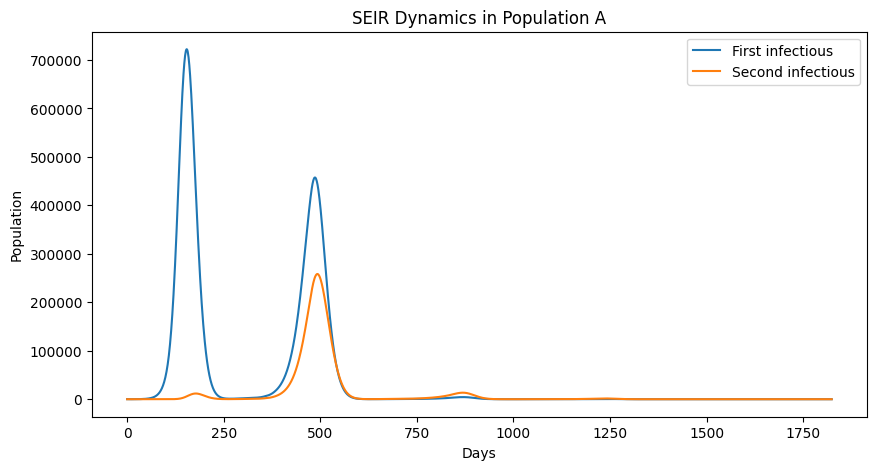

In [ ]:
## results are indexed by [time, compartment, pop]
popA = sol[:,:,0]
popB = sol[:,:,1]
popC = sol[:,:,2]

import matplotlib.pyplot as plt

# To extract the outputs for susceptible, infected and recovered in the area A
time = ts
SV_popA = popA[:, 0] # susceptible mosquitos
IV_popA = np.sum(popA[:, 5:9],axis=1)  # infected mosquitos
S0_popA = popA[:, 9]   # susceptible
E_popA = np.sum(popA[:, 10:14],axis=1)    # exposed
I_popA = np.sum(popA[:, 14:18],axis=1)    # first infection
I1_popA = np.sum(popA[:, 14:15],axis=1)    # first infection with serotype 1
I2_popA = np.sum(popA[:, 15:16],axis=1)    # first infection with serotype 2
I3_popA = np.sum(popA[:, 16:17],axis=1)    # first infection with serotype 3
I4_popA = np.sum(popA[:, 17:18],axis=1)    # first infection with serotype 4
C_popA = np.sum(popA[:, 18:22],axis=1)    # cross-protection (temperal immune)
Snot_popA=np.sum(popA[:, 22:26],axis=1)    # susceptible to other three serotypes
Enot_popA=np.sum(popA[:, 26:38],axis=1)    # exposed to the second serotype
Inot_popA=np.sum(popA[:, 38:50],axis=1)    # second infection
Inot1_popA=np.sum(popA[:, 38:41],axis=1)    # second infection by serotype 1
Inot2_popA=np.sum(popA[:, 41:44],axis=1)    # second infection by serotype 2
Inot3_popA=np.sum(popA[:, 44:47],axis=1)    # second infection by serotype 3
Inot4_popA=np.sum(popA[:, 47:50],axis=1)    # second infection by serotype 4
H_popA=np.sum(popA[:, 50:54],axis=1)    # hosptalized
R_popA = np.sum(popA[:, 54:58],axis=1)    # recovered


plt.figure(figsize=(10, 5))
#plt.plot(time, SV_popA, label='Susceptible mosquitos')
#plt.plot(time, IV_popA, label='infected mosquitos')
#plt.plot(time, S0_popA, label='Susceptible')
#plt.plot(time, E_popA, label='Exoposed')
plt.plot(time, I_popA, label='First infectious')
#plt.plot(time, I1_popA, label='First infectious 1')
#plt.plot(time, I2_popA, label='First infectious 2')
#plt.plot(time, C_popA, label='Temperol immune')
#plt.plot(time, Snot_popA, label='Susceptible_not')
plt.plot(time, Inot_popA, label='Second infectious')
#plt.plot(time, Inot1_popA, label='Second infectious not 1')
#plt.plot(time, Inot2_popA, label='Second infectious not 2')
#plt.plot(time, Inot3_popA, label='Second infectious not 3')
#plt.plot(time, Inot4_popA, label='Second infectious not 4')
#plt.plot(time, H_popA, label='Hospital')
#plt.plot(time, R_popA, label='Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.title('SEIR Dynamics in Population A')
plt.show()
#print(SV_popA)
#print(Inot_popA)

    day  region compartment  value
0   0.0       0          SV    0.0
1   0.0       1          SV    0.0
2   0.0       2          SV    0.0
3   0.0       0         EV1    0.0
4   0.0       1         EV1    0.0
5   0.0       2         EV1    0.0
6   0.0       0         EV2    0.0
7   0.0       1         EV2    0.0
8   0.0       2         EV2    0.0
9   0.0       0         EV3    0.0
10  0.0       1         EV3    0.0
11  0.0       2         EV3    0.0
12  0.0       0         EV4    0.0
13  0.0       1         EV4    0.0
14  0.0       2         EV4    0.0


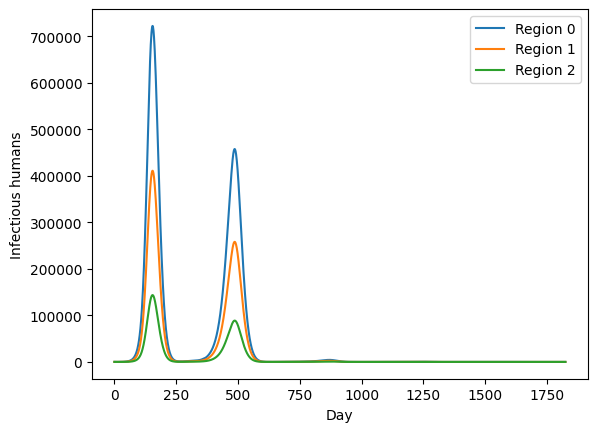

In [ ]:
# =========================
# Post-processing helpers
# =========================

compartments = [
    "SV", "EV1", "EV2", "EV3", "EV4", "IV1", "IV2", "IV3", "IV4",
    "S0", "E1", "E2", "E3", "E4", "I1", "I2", "I3", "I4",
    "C1", "C2", "C3", "C4",
    "Snot1", "Snot2", "Snot3", "Snot4",
    "E12", "E13", "E14", "E21", "E23", "E24", "E31", "E32", "E34", "E41", "E42", "E43",
    "I12", "I13", "I14", "I21", "I23", "I24", "I31", "I32", "I34", "I41", "I42", "I43",
    "H1", "H2", "H3", "H4",
    "R1", "R2", "R3", "R4",
    # ---- appended totals (8) ----
    "E_total", "I_total", "C_total", "Snot_total",
    "E2_total", "I2_total", "H_total", "R_total",
]

records = []
for ti, day in enumerate(ts):
    for ci, cname in enumerate(compartments):
        for ri in range(n_regions):
            records.append({
                "day": float(day),
                "region": ri,
                "compartment": cname,
                "value": float(sol[ti, ci, ri])
            })

df = pd.DataFrame(records)

print(df.head(15))

# =========================
# Example quick plots
# =========================
import matplotlib.pyplot as plt

for ri in range(n_regions):
    total_I = sol[:, compartments.index("I1"), ri] \
            + sol[:, compartments.index("I2"), ri] \
            + sol[:, compartments.index("I3"), ri] \
            + sol[:, compartments.index("I4"), ri]
    plt.plot(ts, total_I, label=f"Region {ri}")

plt.xlabel("Day")
plt.ylabel("Infectious humans")
plt.legend()
plt.show()


## Wrap-up and next steps

- ✅ Congratulations! You have run the Dengue model.
- 📦 Outputs are saved as described above.  
- 🔁 To iterate, tweak parameters in *Configure parameters* and re-run the dependent sections.

---
